In [14]:
import numpy as np
import torch
import xarray as xr
from tqdm import tqdm
import include as base
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rcParams
from cycler import cycler
colors = {
    
    'c_darkblue': '#2F7194',
    'c_red': '#ec7070',
    'c_darkgreen': '#48675A',
    'c_lightblue': '#97c3d0',
    'c_lightgreen': '#AFD8BC',
    'c_lightbrown': '#C6BFA2',
    'c_orange': '#EC9F7E',
    'c_yellow': '#F5DDA9',
    'c_darkgrey': '#3D4244',
    'c_pink': '#F8A6A6',
    'c_purple': '#A07CB0',
    'c_lightgrey': '#AFC1B9',
}
rcParams['axes.prop_cycle'] = cycler(color=list(colors.values()))
fs=9
rcParams.update(**{
    "text.usetex": True,
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage{amssymb} \usepackage{amsmath}",
    "font.size": fs, 
    "axes.titlesize": fs,
    "axes.labelsize": fs,
    "xtick.labelsize": fs,
    "ytick.labelsize": fs,
    "legend.fontsize": fs,
    "grid.linewidth": 0.5,
    "savefig.bbox": "tight",
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False
})

In [208]:
# Load in the pooled FAOStat data (95%, 1995-2022)
FAO_data = xr.open_dataarray("/Users/thomasgaskin/FAOSTAT_data/Bananas/All_Data_Bananas_Quantity_2000-2022_pooled_0.95.nc")

In [209]:
# Reshape the 'Year' and 'Reporter' dimensions into a single 'idx' dimension, drop, and transform into a torch.Tensor
training_data = torch.from_numpy(
    FAO_data.stack({'idx': ['Year', 'Reporter']}).drop_vars(['Year', 'Reporter']).transpose('idx', ...).data
).float()

M, N = training_data.shape[1:]

# Calculate the marginals
mu, nu = torch.nansum(training_data, dim=-1, keepdim=True), torch.nansum(training_data, dim=1, keepdim=True)

# Get the mask for each training dset: NaN values to do not contribute to the loss function
mask = training_data > 0

In [210]:
# Replace NaNs in the training data with -1
training_data[torch.isnan(training_data)] = -1

In [211]:
# Initialise the Neural Network
NN = base.NeuralNet(
    input_size=M * N,
    output_size=M * N,
    num_layers=5,
    nodes_per_layer=dict(default=60),
    activation_funcs=dict(default='tanh', layer_specific={-1: 'sigmoid'}),
    biases=dict(default=None),
    optimizer='Adam',
    learning_rate=0.002
)

In [212]:
training_data.shape

torch.Size([46, 45, 66])

In [286]:
# Train
num_epochs = 15000
batch_size = 23

# Kwargs for the Sinkhorn algorithm
sinkhorn_kwargs = dict(max_iter=100, tolerance=1e-5, epsilon = 0.15)

loss_ts = []

# Train
for it in (pbar := tqdm(range(num_epochs))):
    
    epoch_loss = []
    epoch_accuracy = []
    loss = torch.tensor(0.0, requires_grad=True)
    for j, dset in enumerate(training_data):

        # Make a prediction
        _C_pred = NN(dset.reshape(M * N, )).reshape(M, N)
        
        # Get the marginals from the predicted cost matrix
        m, n = base.Sinkhorn(
            mu[j],
            nu[j],
            _C_pred,
            **sinkhorn_kwargs,
        )

        _, _, _T_pred = base.marginals_and_transport_plan(m, n, _C_pred, epsilon=sinkhorn_kwargs["epsilon"])
        
        training_loss = torch.nn.functional.mse_loss(
            _T_pred[mask[j]], dset[mask[j]]
        )
        loss = loss +  training_loss
        
        if j % batch_size == 0 or j == training_data.shape[0] - 1:
            loss.backward()
            NN.optimizer.step()
            NN.optimizer.zero_grad()
            loss = torch.tensor(0.0, requires_grad=True)

        epoch_loss.append(torch.mean(abs(_T_pred.detach()[mask[j]] - dset[mask[j]])/ dset[mask[j]]))
    
    loss_ts.append(np.mean(epoch_loss).item())
    pbar.set_description(f"Current accuracy: {np.round(loss_ts[-1], 2)}")

Current accuracy: 81.05:  32%|███▏      | 4732/15000 [28:41<1:02:14,  2.75it/s] 


KeyboardInterrupt: 

In [292]:
# Save the trained NN
# torch.save(NN.state_dict(), "/Users/thomasgaskin/FAOSTAT_data/Bananas/trained_NN.pt")
# NN2 = base.NeuralNet(
#     input_size=M * N,
#     output_size=M * N,
#     num_layers=5,
#     nodes_per_layer=dict(default=60),
#     activation_funcs=dict(default='tanh', layer_specific={-1: 'sigmoid'}),
#     biases=dict(default=None),
#     optimizer='Adam',
#     learning_rate=0.002
# )
# NN2.load_state_dict(torch.load("/Users/thomasgaskin/FAOSTAT_data/Bananas/trained_NN.pt"))

<All keys matched successfully>

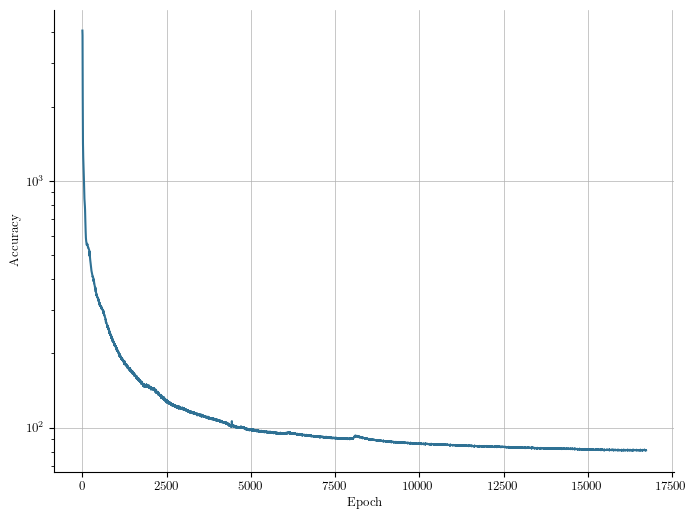

In [287]:
# Plot the training loss
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(len(loss_ts)), np.array(loss_ts))
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
# ax.set_ylim(0, 1)
ax.set_yscale('log')
# plt.savefig("/Users/thomasgaskin/NN_accuracy.pdf", bbox_inches='tight')

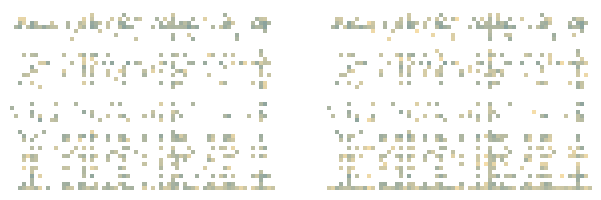

In [296]:
# Plot an example prediction on the training data
idx = np.random.choice(len(training_data), 1)[0]
example_dset = training_data[idx]
_C_pred = NN(example_dset.reshape(M * N, )).reshape(M, N).detach()

# Get the marginals from the predicted cost matrix
m, n = base.Sinkhorn(
    mu[idx],
    nu[idx],
    _C_pred,
    **sinkhorn_kwargs,
)

_, _, _T_pred = base.marginals_and_transport_plan(m, n, _C_pred, epsilon=sinkhorn_kwargs["epsilon"])

from dantro.plot.utils import ColorManager
cm = ColorManager(
    cmap={'from_values': {0: colors['c_yellow'], 1: colors['c_darkblue']}, 'continuous': True}, vmin=0, vmax=1
)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(7.5, 3.75))
for ax in axs:
    ax.grid()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
axs.flatten()[0].imshow(np.ma.masked_where(example_dset == -1, example_dset / 1e6), vmin=0, vmax=example_dset.max(), cmap=cm.cmap, norm='log')
axs.flatten()[1].imshow(np.ma.masked_where(example_dset == -1, _T_pred / 1e6), vmin=0, vmax=example_dset.max(), cmap=cm.cmap, norm='log')
# plt.savefig("/Users/thomasgaskin/NN_T_predictions.pdf", bbox_inches='tight', dpi=600)

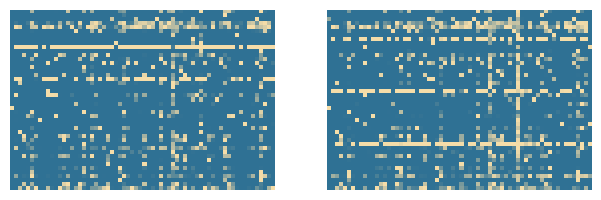

In [297]:
# Plot two example cost matrices
_C_pred_1 = NN2(training_data[np.random.choice(len(training_data), 1)[0]].reshape(M * N, )).reshape(M, N).detach()
_C_pred_2 = NN2(training_data[np.random.choice(len(training_data), 1)[0]].reshape(M * N, )).reshape(M, N).detach()

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(7.5, 3.75))

for ax in axs:
    ax.grid()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
axs[0].imshow(_C_pred_1, vmin=0, vmax=1, cmap=cm.cmap)
axs[1].imshow(_C_pred_2, vmin=0, vmax=1, cmap=cm.cmap)
plt.savefig("/Users/thomasgaskin/NN_cost_predictions.pdf", bbox_inches='tight', dpi=600)

In [277]:
# Now generate predictions on the FAOStat data by randomly picking one of the reporter values for each Year, where available.

# Number of samples for each year
N_samples = 1000

samples = xr.Dataset(
    data_vars=dict(
        C=(["Year", "Sample", "Country A", "Country B"], np.zeros((len(FAO_data.coords['Year'].data), N_samples, M, N))), 
        T=(["Year", "Sample", "Country A", "Country B"], np.zeros((len(FAO_data.coords['Year'].data), N_samples, M, N)))
    ), 
    coords={"Sample": np.arange(N_samples), 
            "Year": FAO_data.coords["Year"].data, 
            "Country A": FAO_data.coords["Country A"].data, 
            "Country B": FAO_data.coords["Country B"].data}
)

for j in tqdm(range(N_samples), desc="Sampling"):

    for year in FAO_data.coords['Year'].data:

        # Pick random entries along the 'Reporter' axis and fill NaN values
        _dset = torch.from_numpy(
            np.apply_along_axis(np.random.choice, -1, FAO_data.sel({'Year': year}, drop=True), 1).squeeze(-1)
        ).float()

        _dset[torch.isnan(_dset)] = -1.0

        _C_pred = NN(_dset.reshape(M * N, )).reshape(M, N).detach()
        _C_pred[_dset == -1] = torch.nan
        _dset[_dset == -1] = torch.nan
        samples["C"].loc[{"Year": year, "Sample": j}] = _C_pred
        samples["T"].loc[{"Year": year, "Sample": j}] = _dset

100%|██████████| 1000/1000 [07:23<00:00,  2.26it/s]


/Users/thomasgaskin/NeuralABM/venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/thomasgaskin/NeuralABM/venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/thomasgaskin/NeuralABM/venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/thomasgaskin/NeuralABM/venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/thomasgaskin/NeuralABM/venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

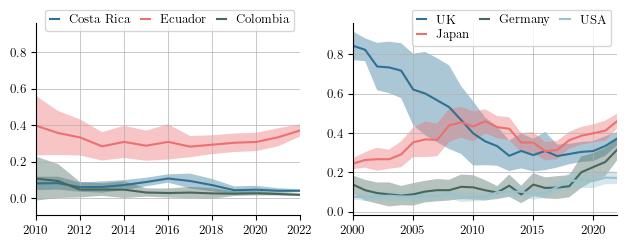

In [278]:
fig, axs = plt.subplots(ncols=2, figsize=(7.5, 2.5))

importer = "UK"
exporter = "Ecuador"
for _country in ["Costa Rica", "Ecuador", "Colombia"]:
    
    # Plot the cost trajectory for the importer
    _mean = samples["C"].mean("Sample", skipna=True).sel({"Country A": _country, "Country B": importer}, drop=True)
    _std = samples["C"].std("Sample", skipna=True).sel({"Country A": _country, "Country B": importer}, drop=True) 
    
    axs[0].fill_between(_mean.coords['Year'].data, _mean - _std, _mean + _std, alpha=0.4)
    axs[0].plot(_mean.coords['Year'], _mean, label=_country)
axs[0].set_xlim(2010, 2022)
axs[0].legend(title="", ncol=3, loc="upper right", bbox_to_anchor=(0, 1, 1, 0.1), handlelength=0.75, labelspacing=0.3, columnspacing=0.8)

for _country in ["UK", "Japan", "Germany", "USA"]:
    
    # Plot the cost trajectory for the exporter
    _mean = samples["C"].mean("Sample", skipna=True).sel({"Country B": _country, "Country A": exporter}, drop=True) 
    _std = samples["C"].std("Sample", skipna=True).sel({"Country B": _country, "Country A": exporter}) 

    axs[1].fill_between(_mean.coords['Year'].data, _mean - _std, _mean + _std, alpha=0.4)
    axs[1].plot(_mean.coords['Year'], _mean, label=_country)

axs[1].set_xlim(2000, 2022)
axs[1].legend(title="", ncol=3, loc="upper right", bbox_to_anchor=(0, 1, 1, 0.1), handlelength=0.75, labelspacing=0.3, columnspacing=0.8)
# plt.savefig("/Users/thomasgaskin/NN_cost_comparison.pdf", bbox_inches='tight', dpi=600)

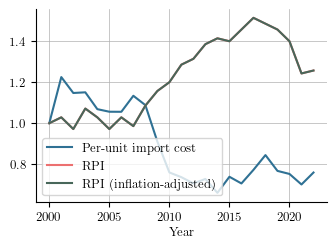

In [282]:
# Calculate the predicted RPI for the UK
UK_import_mean_cost = (samples["C"].mean("Sample", skipna=True).sel({"Country B": "UK"}, drop=True) * samples["T"].mean("Sample", skipna=True).sel({"Country B": "UK"}, drop=True)).sum("Country A", skipna=True) / samples["T"].mean("Sample", skipna=True).sel({"Country B": "UK"}, drop=True).sum("Country A", skipna=True)

UK_import_mean_cost /= UK_import_mean_cost.sel({"Year": 2000}) # Normalise to 2010 levels

# UK inflation rate, 2010-2022
# UK_inflation_rate = np.array([0.0249, 0.0386, 0.0257, 0.0229, 0.0145, 0.0037, 0.0101, 0.0256, 0.0229, 0.0174, 0.0099, 0.0252, 0.0792])

# Load the RPI
import pandas as pd
RPI_data = pd.read_csv('../../data/IOT/ONS_RPI/Avocados_Pears_Feb_24.csv', index_col=0).astype(float).to_xarray().to_array().squeeze(drop=True).sel({"Year": slice(2000, 2022)})


fig, ax = plt.subplots(figsize=(3.75, 2.5))
(UK_import_mean_cost).plot(ax=ax, label='Per-unit import cost')

# Plot the RPI
(RPI_data / RPI_data.isel({"Year": 0})).plot(ax=ax, label='RPI')

# Adjust the RPI for inflation
# RPI_data *= np.array([np.prod(1-UK_inflation_rate[:i]) for i in range(len(UK_inflation_rate+1))])
(RPI_data / RPI_data.isel({"Year": 0})).plot(ax=ax, label='RPI (inflation-adjusted)')
ax.legend()
# plt.savefig("/Users/thomasgaskin/NN_RPI_comparison.pdf", bbox_inches='tight', dpi=600)

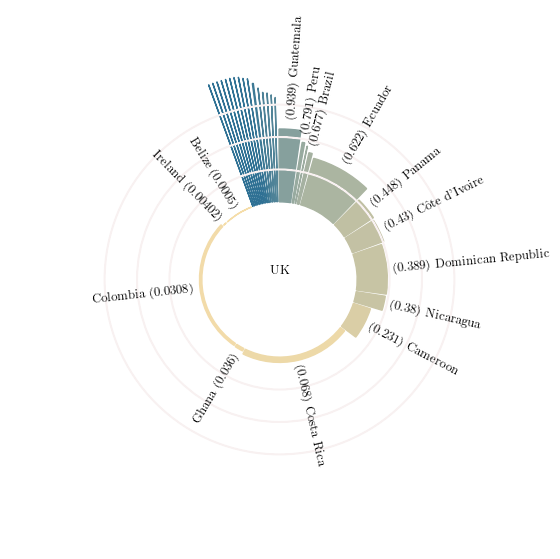

In [283]:
# Plot a pie-chart of the import volume and cost
from pie_chart import pie
_data = samples.mean("Sample", skipna=True).sel({"Country B": "UK", "Year": 2022}, drop=True)
_data = _data.where(_data["T"] > 0, drop=True)
plt = pie(
    _data.sortby("C") / _data["C"].mean(),
    x="T", 
    y="C", 
    hue="C",
    cmap=cm.cmap,
    title="UK",
    start_angle=110,
    end_angle=470,
    inner_padding_factor=2000,
    subplot_kwargs=dict(figsize=(7, 7))
)
# plt.savefig("/Users/thomasgaskin/NN_UK_pie_chart.pdf", bbox_inches='tight', dpi=600)

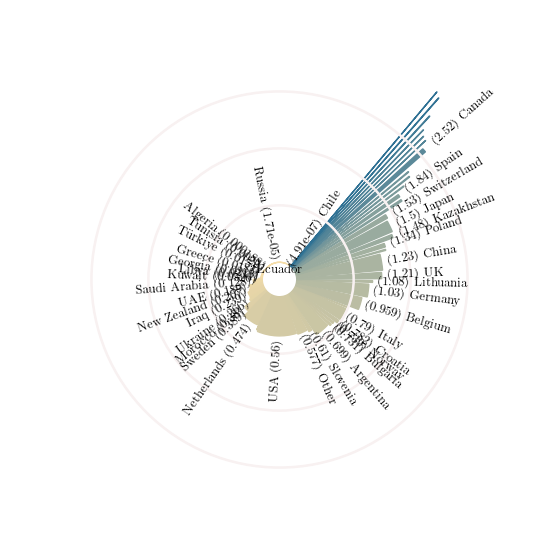

In [284]:
_data = samples.mean("Sample", skipna=True).sel({"Country A": "Ecuador", "Year": 2022}, drop=True)
_data = _data.where(_data["T"] > 0, drop=True)
plt = pie(
    _data.sortby("C") / _data["C"].mean(),
    x="T", 
    y="C", 
    hue="C",
    cmap=cm.cmap,
    title="Ecuador",
    outer_padding=1.1,
    start_angle=50,
    inner_padding_factor=500000,
    subplot_kwargs=dict(figsize=(7, 7))
)
# plt.savefig("/Users/thomasgaskin/NN_Mexico_pie_chart.pdf", bbox_inches='tight', dpi=600)

Text(0, 0.5, '')

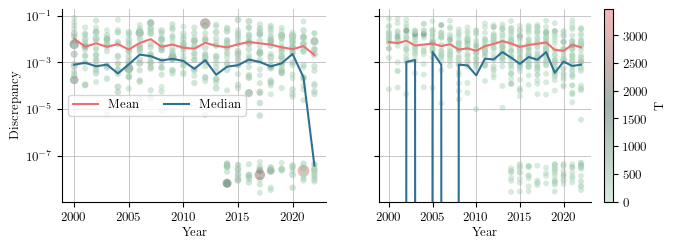

In [285]:
# Plot the discrepancy on the trade matrix
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(7.5, 2.5), sharey=True, sharex=True)

cm = ColorManager(
    cmap={'from_values': {0: colors['c_lightgreen'], 0.5: colors["c_darkgreen"], 1: colors['c_red']}, 'continuous': True}, norm="LogNorm"
)

ds1 = xr.Dataset(
    dict(Discrepancy = abs(samples.mean("Sample", skipna=True).sel({"Country B": "UK"}, drop=True)["T"] - FAO_data.sel({"Year": slice(2000, None), "Country B": "UK"}, drop=True).mean("Reporter")) / FAO_data.sel({"Year": slice(2000, None), "Country B": "UK"}, drop=True).mean("Reporter"),
         T = samples.mean("Sample", skipna=True).sel({"Country B": "UK"}, drop=True)["T"] / samples.mean("Sample", skipna=True).sel({"Country B": "UK"}, drop=True)["T"].sum("Year")
         ))

ds1.fillna(0).plot.scatter(x="Year", y="Discrepancy", markersize="T", hue="T", ax=axs[0], lw=0, alpha=0.5, add_legend=False, cmap=cm.cmap, add_colorbar=False)
ds1["Discrepancy"].mean("Country A", skipna=True).plot.line(ax=axs[0], color=colors["c_red"], label="Mean")
ds1["Discrepancy"].median("Country A", skipna=True).plot.line(ax=axs[0], color=colors["c_darkblue"], label="Median")
axs[0].set_yscale('log')
axs[0].legend(ncol=2)

ds2 = xr.Dataset(
    dict(Discrepancy = abs(samples.mean("Sample", skipna=True).sel({"Country A": "Costa Rica"}, drop=True)["T"] - FAO_data.sel({"Year": slice(2000, None), "Country A": "Costa Rica"}, drop=True).mean("Reporter")) / FAO_data.sel({"Year": slice(2000, None), "Country A": "Costa Rica"}, drop=True).mean("Reporter"),
         T = samples.mean("Sample", skipna=True).sel({"Country A": "Costa Rica"}, drop=True)["T"] / samples.mean("Sample", skipna=True).sel({"Country A": "Mexico"}, drop=True)["T"].sum("Year")
         ))

ds2.fillna(0).plot.scatter(x="Year", y="Discrepancy", markersize="T", hue="T", ax=axs[1], lw=0, alpha=0.5, add_legend=False, cmap=cm.cmap)
ds2["Discrepancy"].mean("Country B", skipna=True).plot.line(ax=axs[1], color=colors["c_red"], label="Mean")
ds2["Discrepancy"].median("Country B", skipna=True).plot.line(ax=axs[1], color=colors["c_darkblue"], label="Median")
axs[1].set_yscale('log')
axs[1].set_ylabel('')
# plt.savefig("/Users/thomasgaskin/NN_discrepancies.pdf", bbox_inches='tight', dpi=600)